# Final Project Title
## Brendan, Nathan, Yash, Rennie

## Introduction
### We want to find the most optimal deck in terms of win rate. We will do this by looking at both individual cards and decks. We will analyze cards based on rarity and elixer and decks based on average elixer and deck composition in terms of types of cards.

## Data Collection/Curation
### We got this data from Kaggle. Provide link to kaggle site. These datasets include ... . Describe the process of adding relevant information to card_list including type of card, rarity, elixer cost, if its flying, if it spawns units etc.

## Data management/representation

### Discuss reading data into pandas
### Discuss creating a dataframe that contains each deck and information about the deck
### Discuss creating a dataframe that contains each card and information about the card

In [70]:
# Imports
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
from collections import Counter
import math
from scipy.stats import pearsonr
from scipy.stats import spearmanr

In [2]:
data_games = pd.read_csv("data_ord.csv")
data_cards = pd.read_csv("cardlist.csv")

In [9]:
# Deck Section
# Extracting interesting deck data
dict_decks_general = {} 
dict_decks_general = defaultdict(lambda:0,dict_decks_general)
dict_decks_winning_only = {} 
dict_decks_winning_only = defaultdict(lambda:0,dict_decks_winning_only)
def get_decks(p1_deck,p2_deck,result):
    global dict_decks_general
    global dict_decks_winning_only
    dict_decks_general[p1_deck] = dict_decks_general[p1_deck] + 1
    dict_decks_general[p2_deck] = dict_decks_general[p2_deck] + 1
    if(result == 1):
        dict_decks_winning_only[p1_deck] = dict_decks_winning_only[p1_deck] + 1
    else:
        dict_decks_winning_only[p2_deck] = dict_decks_winning_only[p2_deck] + 1
        
data_games.apply(lambda x: get_decks((x["p1card1"],x["p1card2"],x["p1card3"],x["p1card4"],x["p1card5"],x["p1card6"],x["p1card7"],x["p1card8"]),(x["p2card1"],x["p2card2"],x["p2card3"],x["p2card4"],x["p2card5"],x["p2card6"],x["p2card7"],x["p2card8"]),x["outcome"]), axis=1)

data_decks = pd.DataFrame.from_dict([dict_decks_general]).transpose().reset_index().rename(columns={"index": "Deck", 0: "Occurrences"})
data_decks['Wins'] = data_decks['Deck'].apply(lambda x: dict_decks_winning_only[x])
data_decks

,Deck,Occurrences
0,"(8, 34, 37, 52, 69, 88, 92, 97)",30
1,"(11, 12, 13, 58, 77, 86, 87, 98)",22
2,"(11, 37, 53, 83, 88, 92, 97, 102)",183
3,"(19, 22, 25, 32, 54, 76, 87, 98)",1778
4,"(28, 38, 43, 46, 50, 81, 102, 103)",1910
...,...,...
327653,"(7, 15, 17, 21, 43, 81, 87, 89)",1
327654,"(13, 35, 39, 43, 48, 73, 95, 99)",1
327655,"(11, 17, 18, 24, 51, 77, 95, 102)",1
327656,"(4, 7, 11, 21, 64, 77, 88, 92)",1


In [26]:
# Obtain deck specific info
comps = []
rarities = []
costs = []
def findComp(deck):
    global comps
    global rarities
    comp = 0
    rarity = 0
    total = 0
    for card in deck:
        curr_type = data_cards.loc[card].type
        curr_rarity = data_cards.loc[card].rarity
        total += data_cards.loc[card].cost
        if(curr_type == "unit"):
            comp += 1
        elif(curr_type == "spell"):
            comp += 10
        elif(curr_type == "defense" or curr_type == "spawner" or curr_type == "siege" or curr_type == "building"):
            comp += 100
        
        if(curr_rarity == "common"):
            rarity += 1
        elif(curr_rarity == "rare"):
            rarity += 10
        elif(curr_rarity == "epic"):
            rarity += 100
        elif(curr_rarity == "legendary"):
            rarity += 1000
        elif(curr_rarity == "champion"):
            rarity += 10000
    comps.append(str(comp).zfill(3))
    rarities.append(str(rarity).zfill(5))
    costs.append(total/8)
    
    
data_decks['Deck'].apply(lambda x: findComp(x))
data_decks['Rarity'] = rarities
data_decks['Composition'] = comps
data_decks['Costs'] = costs
data_decks['Win Rate'] = data_decks.apply(lambda x: x['Wins']/x['Occurrences'], axis=1)
data_decks.head()

,Deck,Occurrences,Wins,Composition,Rarity,Costs,Win Rate
0,"(8, 34, 37, 52, 69, 88, 92, 97)",30,17,035,12212,4.25,0.566667
1,"(11, 12, 13, 58, 77, 86, 87, 98)",22,9,224,01331,3.25,0.409091
2,"(11, 37, 53, 83, 88, 92, 97, 102)",183,83,143,02213,3.75,0.453552
3,"(19, 22, 25, 32, 54, 76, 87, 98)",1778,959,125,02213,3.50,0.539370
4,"(28, 38, 43, 46, 50, 81, 102, 103)",1910,1064,116,02141,4.00,0.557068


## Data Analysis

In [85]:
# Finding the 5 most common decks
display(data_decks.sort_values(by=['Occurrences'], ascending=False).head(5))


,Deck,Occurrences,Wins,Composition,Rarity,Costs,Win Rate
13,"(10, 14, 21, 30, 38, 74, 87, 98)",32405,15767,125,01043,2.625,0.486561
27,"(4, 36, 42, 46, 50, 62, 87, 95)",24027,12734,026,04121,3.875,0.529987
176,"(0, 26, 30, 41, 77, 90, 91, 98)",18166,8849,134,02123,3.250,0.487119
14,"(6, 34, 35, 37, 63, 92, 99, 102)",16286,9002,035,02600,4.000,0.552745
43,"(0, 1, 10, 72, 80, 82, 87, 98)",10385,5229,224,01115,3.000,0.503515


In [83]:
# Finding the 5 most winning decks
display(data_decks.sort_values(by=['Wins'], ascending=False).head(5))

,Deck,Occurrences,Wins,Composition,Rarity,Costs,Win Rate
13,"(10, 14, 21, 30, 38, 74, 87, 98)",32405,15767,125,01043,2.625,0.486561
27,"(4, 36, 42, 46, 50, 62, 87, 95)",24027,12734,026,04121,3.875,0.529987
14,"(6, 34, 35, 37, 63, 92, 99, 102)",16286,9002,035,02600,4.000,0.552745
176,"(0, 26, 30, 41, 77, 90, 91, 98)",18166,8849,134,02123,3.250,0.487119
43,"(0, 1, 10, 72, 80, 82, 87, 98)",10385,5229,224,01115,3.000,0.503515


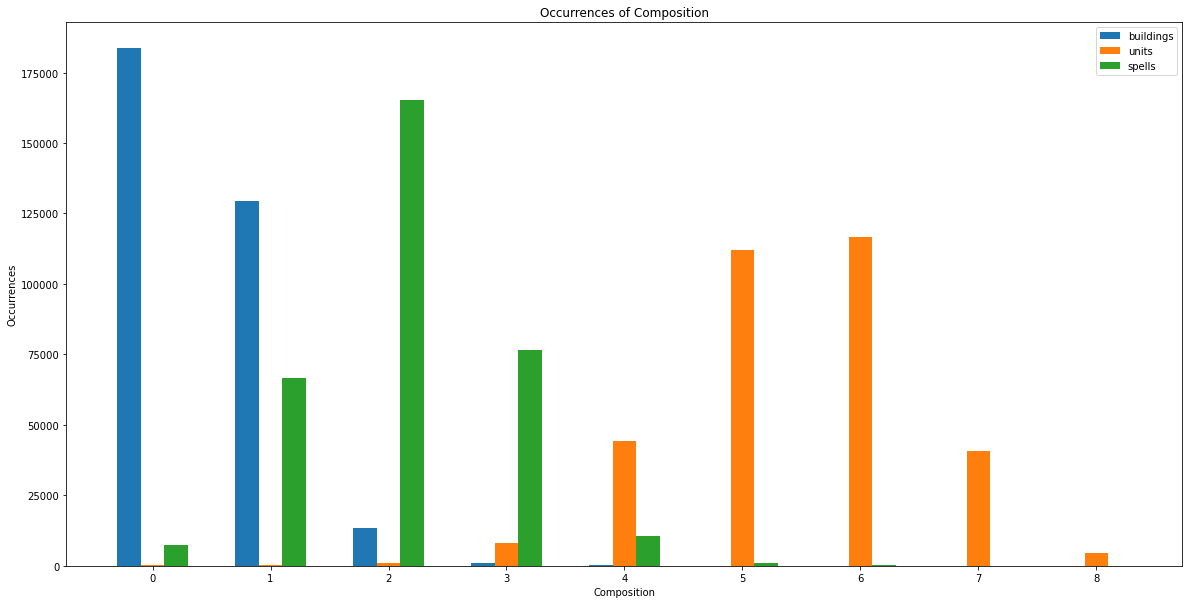

In [148]:
units = data_decks['Composition'].apply(lambda x: int(x[2])).value_counts()
spells = data_decks['Composition'].apply(lambda x: int(x[1])).value_counts()
buildings = data_decks['Composition'].apply(lambda x: int(x[0])).value_counts()

# Creating plot
fig, ax = plt.subplots(figsize=(20,10))
# Setting labels
ax.set_ylabel("Occurrences")
ax.set_xlabel("Composition")
ax.set_title("Occurrences of Composition")
# Plotting occurrences of each composition
ax.bar(buildings.index-.2, buildings.values, .2, label='buildings')
ax.bar(units.index, units.values, .2, label='units')
ax.bar(spells.index + .2, spells.values, .2, label='spells')
ax.set_xticks(np.arange(9), ['0','1','2','3','4','5','6','7','8'])
plt.legend(loc="upper right")
fig.show()

In [120]:
# Finding the 5 most common general compositions
# Generally, a lower number of buildings
print(data_decks['Composition'].value_counts()[0:5])
comps = data_decks['Composition'].value_counts().index[0:5]

for comp in comps:
    # Finding most popular deck of each composition in the top 5
    display(data_decks[data_decks['Composition'] == comp].sort_values(by=['Occurrences'], ascending=False).head(1))

026    91676
125    66117
035    42565
017    38373
134    31398
Name: Composition, dtype: int64


,Deck,Occurrences,Wins,Composition,Rarity,Costs,Win Rate
27,"(4, 36, 42, 46, 50, 62, 87, 95)",24027,12734,026,04121,3.875,0.529987


,Deck,Occurrences,Wins,Composition,Rarity,Costs,Win Rate
13,"(10, 14, 21, 30, 38, 74, 87, 98)",32405,15767,125,01043,2.625,0.486561


,Deck,Occurrences,Wins,Composition,Rarity,Costs,Win Rate
14,"(6, 34, 35, 37, 63, 92, 99, 102)",16286,9002,035,02600,4.0,0.552745


,Deck,Occurrences,Wins,Composition,Rarity,Costs,Win Rate
326,"(19, 32, 37, 41, 49, 55, 56, 95)",5659,2959,017,03005,3.25,0.522884


,Deck,Occurrences,Wins,Composition,Rarity,Costs,Win Rate
176,"(0, 26, 30, 41, 77, 90, 91, 98)",18166,8849,134,02123,3.25,0.487119


In [174]:
# Finding 5 least common compositions
# Generally a higher number of buildings
print(data_decks['Composition'].value_counts()[40:45])
comps = data_decks['Composition'].value_counts().index[40:45]

for comp in comps:
    # Finding most popular deck of each composition in the top 5
    for card in data_decks[data_decks['Composition'] == comp].sort_values(by=['Occurrences'], ascending=False).head(1)['Deck'].values[0]:
        deck = deck + " " + data_cards.loc[card].card + ","
    print(deck[:-1])

611    5
800    5
701    4
602    1
503    1
Name: Composition, dtype: int64
 Skeleton Army, Prince, Royal Giant, Princess, Dart Goblin, Bats, Mega Knight, Goblin Barrel, Fire Spirit, Goblin Hut, Bomb Tower, Barbarian Hut, Tesla, Tombstone, Furnace, Mirror
 Skeleton Army, Prince, Royal Giant, Princess, Dart Goblin, Bats, Mega Knight, Goblin Barrel, Fire Spirit, Goblin Hut, Bomb Tower, Barbarian Hut, Tesla, Tombstone, Furnace, Mirror, Cannon, Goblin Hut, Mortar, Barbarian Hut, Tesla, X-Bow, Tombstone, Furnace
 Skeleton Army, Prince, Royal Giant, Princess, Dart Goblin, Bats, Mega Knight, Goblin Barrel, Fire Spirit, Goblin Hut, Bomb Tower, Barbarian Hut, Tesla, Tombstone, Furnace, Mirror, Cannon, Goblin Hut, Mortar, Barbarian Hut, Tesla, X-Bow, Tombstone, Furnace, Cannon Cart, Inferno Tower, Bomb Tower, Barbarian Hut, Tesla, X-Bow, Furnace, Goblin Drill
 Skeleton Army, Prince, Royal Giant, Princess, Dart Goblin, Bats, Mega Knight, Goblin Barrel, Fire Spirit, Goblin Hut, Bomb Tower, Barbar

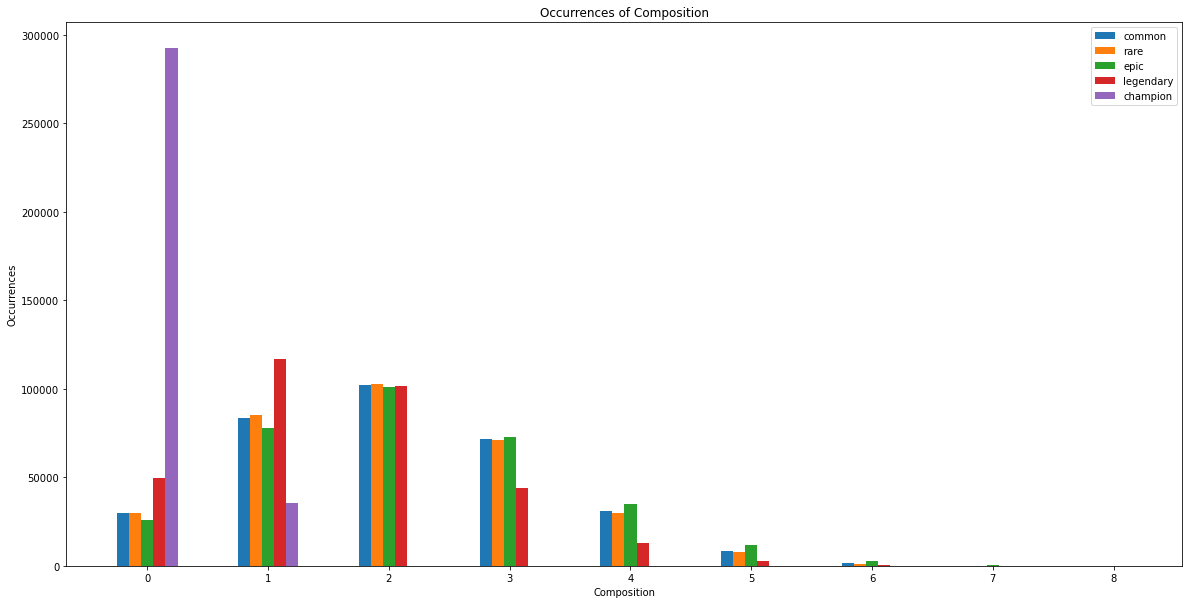

In [150]:
common = data_decks['Rarity'].apply(lambda x: int(x[4])).value_counts()
rare = data_decks['Rarity'].apply(lambda x: int(x[3])).value_counts()
epic = data_decks['Rarity'].apply(lambda x: int(x[2])).value_counts()
legendary = data_decks['Rarity'].apply(lambda x: int(x[1])).value_counts()
champion = data_decks['Rarity'].apply(lambda x: int(x[0])).value_counts()

# Creating plot
fig, ax = plt.subplots(figsize=(20,10))
# Setting labels
ax.set_ylabel("Occurrences")
ax.set_xlabel("Composition")
ax.set_title("Occurrences of Rarity")
# Plotting occurrences of each composition
ax.bar(common.index-.2, common.values, .1, label='common')
ax.bar(rare.index-.1, rare.values, .1, label='rare')
ax.bar(epic.index, epic.values, .1, label='epic')
ax.bar(legendary.index+.1, legendary.values, .1, label='legendary')
ax.bar(champion.index+.2, champion.values, .1, label='champion')

ax.set_xticks(np.arange(9), ['0','1','2','3','4','5','6','7','8'])
plt.legend(loc="upper right")
fig.show()

In [173]:
# Finding the 5 most common compositions
# Generally, a lower number of buildings
print(data_decks['Rarity'].value_counts()[0:5])
rars = data_decks['Rarity'].value_counts().index[0:5]

for rar in rars:
    # Finding most popular deck of each composition in the top 5
    deck = ""
    for card in data_decks[data_decks['Rarity'] == rar].sort_values(by=['Occurrences'], ascending=False).head(1)['Deck'].values[0]:
        deck = deck + " " + data_cards.loc[card].card + ","
    print(deck[:-1])

02222    11973
01322    10339
01232    10236
01223    10209
02312     8140
Name: Rarity, dtype: int64
 Prince, Princess, Dart Goblin, Goblin Gang, Rascals, Rocket, Goblin Barrel, The Log
 Golem, Bomber, Baby Dragon, Mini P.E.K.K.A, Mega Minion, Night Witch, Arrows, Lightning
 Balloon, Skeletons, Musketeer, Miner, Ice Golem, Bomb Tower, Barbarian Barrel, Giant Snowball
 Balloon, Guards, Lava Hound, Mega Minion, Skeleton Dragons, Tombstone, Fireball, Zap
 Skeleton Army, Prince, Royal Giant, Princess, Dart Goblin, Bats, Mega Knight, Goblin Barrel


In [170]:
# Finding the 5 most common compositions
# Generally, a lower number of buildings
print(data_decks['Rarity'].value_counts()[280:285])
rars = data_decks['Rarity'].value_counts().index[280:285]

for rar in rars:
    # Finding most popular deck of each composition in the top 5
    deck = ""
    for card in data_decks[data_decks['Rarity'] == rar].sort_values(by=['Occurrences'], ascending=False).head(1)['Deck'].values[0]:
        deck = deck + " " + data_cards.loc[card].card + ","
    print(deck[:-1])

10160    4
11060    4
00080    4
10070    1
10007    1
Name: Rarity, dtype: int64
 Dart Goblin, Zappies, Flying Machine, Royal Hogs, Golden Knight, Goblin Cage, Fireball, Barbarian Barrel
 Valkyrie, Mini P.E.K.K.A, Hog Rider, Electro Wizard, Archer Queen, Goblin Hut, Fireball, Earthquake
 Valkyrie, Musketeer, Mini P.E.K.K.A, Hog Rider, Flying Machine, Goblin Hut, Furnace, Fireball
 Giant, Valkyrie, Musketeer, Wizard, Mini P.E.K.K.A, Golden Knight, Inferno Tower, Fireball
 Knight, Skeletons, Bomber, Spear Goblins, Ice Spirit, Goblin Gang, Bats, Archer Queen


#### Analyzing Deck Average Elixir Cost

[Insert intro]

In [ ]:
elixir_analysis = data_decks.copy(deep=True)

elixir_analysis['losses'] = elixir_analysis['Occurrences'] -elixir_analysis['Wins']

elixir_analysis = elixir_analysis[['Deck','Occurrences','Wins','losses','Rarity','Composition','Costs','Trophies','Win Rate']]


elixir_analysis.rename(columns={'Costs':'Average Elixir Cost'},inplace = True)
elixir_analysis

Deck elixir cost versus Winrate scatterplot

In [ ]:
plt.figure().set_figwidth(8)
sns.scatterplot(elixir_analysis, x ='Average Elixir Cost', y = 'Win Rate')


NameError: name 'plt' is not defined

30.0
8264.0
6140.412407816404


<Figure size 800x480 with 0 Axes>

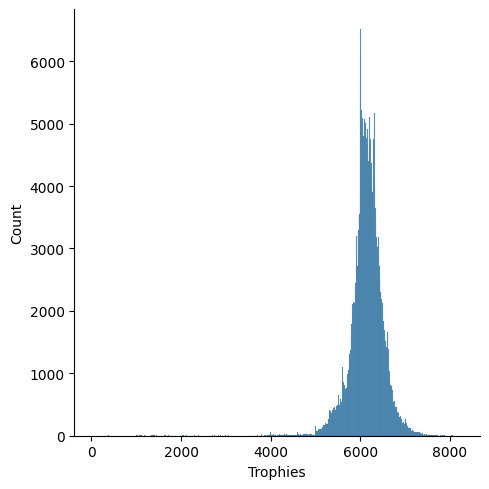

In [ ]:
print(elixir_analysis['Trophies'].min())
print(elixir_analysis['Trophies'].max())
print(elixir_analysis['Trophies'].mean())

plt.figure().set_figwidth(8)
sns.displot(elixir_analysis, x ='Trophies')


In [ ]:
bins = [5000,5500,6000,6500,7000,7500,8500]
label = ['5000-5500','6000-6500','6500-7000','7000-7500','7500-8000','8000-8500']
elixir_analysis['bins'] = pd.cut(elixir_analysis['Trophies'],bins=bins,labels=label)
elixir_analysis

,Deck,Occurrences,Wins,losses,Rarity,Composition,Average Elixir Cost,Trophies,Win Rate,bins
0,"(8, 34, 37, 52, 69, 88, 92, 97)",30,17,13,12212,035,4.250,6963.566667,0.566667,7000-7500
1,"(11, 12, 13, 58, 77, 86, 87, 98)",22,9,13,01331,224,3.250,7339.909091,0.409091,7500-8000
2,"(11, 37, 53, 83, 88, 92, 97, 102)",183,83,100,02213,143,3.750,6996.245902,0.453552,7000-7500
3,"(19, 22, 25, 32, 54, 76, 87, 98)",1778,959,819,02213,125,3.500,6912.115861,0.539370,7000-7500
4,"(28, 38, 43, 46, 50, 81, 102, 103)",1910,1064,846,02141,116,4.000,6769.385864,0.557068,7000-7500
...,...,...,...,...,...,...,...,...,...,...
327653,"(7, 15, 17, 21, 43, 81, 87, 89)",1,1,0,00341,125,4.500,5577.000000,1.000000,6000-6500
327654,"(13, 35, 39, 43, 48, 73, 95, 99)",1,1,0,02213,026,3.875,6087.000000,1.000000,6500-7000
327655,"(11, 17, 18, 24, 51, 77, 95, 102)",1,1,0,01142,125,4.125,5838.000000,1.000000,6000-6500
327656,"(4, 7, 11, 21, 64, 77, 88, 92)",1,0,1,00332,125,4.375,5858.000000,0.000000,6000-6500


/var/folders/d3/r8knfdhd21v56_0frl6_ycl00000gn/T/ipykernel_19473/4229477530.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


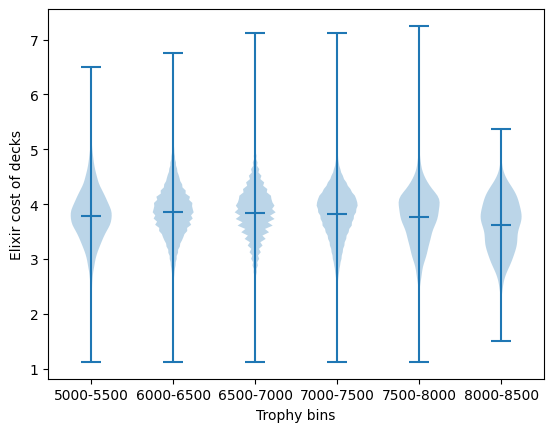

In [ ]:



# getting continents and correspsonding residual
bined = [1,2,3,4,5,6]
avg_elixir = []
elixir_analysis.groupby("bins").apply(lambda x: avg_elixir.append(x["Average Elixir Cost"]))

# Constructing the plot
fig, ax = plt.subplots()
ax.violinplot(avg_elixir,bined,showmeans=True)
# setting labels and title
ax.set_xlabel("Trophy bins")
ax.set_ylabel("Elixir cost of decks")

ax.set_xticks(bined)
ax.set_xticklabels(['5000-5500','6000-6500','6500-7000','7000-7500','7500-8000','8000-8500'])
fig.show()



In [ ]:
win_rate_eli = elixir_analysis['Win Rate']
units_eli = elixir_analysis['Average Elixir Cost']

corr, p = pearsonr(win_rate_eli, units_eli)

print('Pearsons correlation: %.3f' % corr)
print('Pearsons correlation pval: %e' % p)

Pearsons correlation: 0.011
Pearsons correlation pval: 1.022831e-09


This illustrates that there is a weak correlation between win rate and deck elixir cost with a high certainty.   

## Hypothesis Testing

In [81]:
# There is no correlation between number of units and win rate
win_rate = data_decks['Win Rate']
units = data_decks['Composition'].apply(lambda x: int(x[2]))

corr, p = pearsonr(win_rate, units)
print('Pearsons correlation: %.3f' % corr)
print('Pearsons correlation pval: %e' % p)
corr, p = spearmanr(win_rate, units)
print('Spearman correlation: %.3f' % corr)
print('Spearman correlation pval: %e' % p)

# There is no correlation between number of spells and win rate
spells = data_decks['Composition'].apply(lambda x: int(x[1]))

corr, p = pearsonr(win_rate, spells)
print('Pearsons correlation: %.3f' % corr)
print('Pearsons correlation pval: %e' % p)
corr, p = spearmanr(win_rate, spells)
print('Spearman correlation: %.3f' % corr)
print('Spearman correlation pval: %e' % p)

# There is no correlation between number of buildings and win rate
buildings = data_decks['Composition'].apply(lambda x: int(x[0]))

corr, p = pearsonr(win_rate, buildings)
print('Pearsons correlation: %.3f' % corr)
print('Pearsons correlation pval: %e' % p)
corr, _ = spearmanr(win_rate, buildings)
print('Spearman correlation: %.3f' % corr)
print('Spearman correlation pval: %e' % p)

Pearsons correlation: -0.006
Pearsons correlation pval: 7.056334e-04
Spearman correlation: -0.009
Spearman correlation pval: 4.229997e-07
Pearsons correlation: 0.008
Pearsons correlation pval: 2.226059e-06
Spearman correlation: 0.013
Spearman correlation pval: 2.376031e-13
Pearsons correlation: -0.001
Pearsons correlation pval: 4.216646e-01
Spearman correlation: -0.002
Spearman correlation pval: 4.216646e-01


### This illustrates that there is a weak correlation between win rate and composition for units and spells with high certainty. There is a weak correlation between buildings and win rate, but high unertainty about the result.

In [82]:
# There is no correlation between number of commons and win rate
win_rate = data_decks['Win Rate']
common = data_decks['Rarity'].apply(lambda x: int(x[4]))

corr, p = pearsonr(win_rate, common)
print('Pearsons correlation: %.3f' % corr)
print('Pearsons correlation pval: %e' % p)
corr, p = spearmanr(win_rate, common)
print('Spearman correlation: %.3f' % corr)
print('Spearman correlation pval: %e' % p)

rare = data_decks['Rarity'].apply(lambda x: int(x[3]))

corr, p = pearsonr(win_rate, rare)
print('Pearsons correlation: %.3f' % corr)
print('Pearsons correlation pval: %e' % p)
corr, p = spearmanr(win_rate, rare)
print('Spearman correlation: %.3f' % corr)
print('Spearman correlation pval: %e' % p)

epic = data_decks['Rarity'].apply(lambda x: int(x[2]))

corr, p = pearsonr(win_rate, epic)
print('Pearsons correlation: %.3f' % corr)
print('Pearsons correlation pval: %e' % p)
corr, _ = spearmanr(win_rate, epic)
print('Spearman correlation: %.3f' % corr)
print('Spearman correlation pval: %e' % p)

legendary = data_decks['Rarity'].apply(lambda x: int(x[1]))

corr, p = pearsonr(win_rate, legendary)
print('Pearsons correlation: %.3f' % corr)
print('Pearsons correlation pval: %e' % p)
corr, p = spearmanr(win_rate, legendary)
print('Spearman correlation: %.3f' % corr)
print('Spearman correlation pval: %e' % p)

champion = data_decks['Rarity'].apply(lambda x: int(x[0]))

corr, p = pearsonr(win_rate, champion)
print('Pearsons correlation: %.3f' % corr)
print('Pearsons correlation pval: %e' % p)
corr, p = spearmanr(win_rate, champion)
print('Spearman correlation: %.3f' % corr)
print('Spearman correlation pval: %e' % p)

Pearsons correlation: -0.020
Pearsons correlation pval: 4.986060e-29
Spearman correlation: -0.021
Spearman correlation pval: 1.446036e-32
Pearsons correlation: -0.024
Pearsons correlation pval: 3.793463e-42
Spearman correlation: -0.026
Spearman correlation pval: 1.170149e-48
Pearsons correlation: 0.018
Pearsons correlation pval: 1.555940e-25
Spearman correlation: 0.018
Spearman correlation pval: 1.555940e-25
Pearsons correlation: 0.023
Pearsons correlation pval: 1.151631e-38
Spearman correlation: 0.024
Spearman correlation pval: 1.097114e-43
Pearsons correlation: 0.015
Pearsons correlation pval: 4.508260e-17
Spearman correlation: 0.016
Spearman correlation pval: 1.146415e-20


### This illustrates that there is a weak correlation between win rate and rarity with high certainty for all rarities. Notably, it seems that higher rarity leads to higher win rates.

In [160]:
win_rate = data_decks['Win Rate']
units = data_decks['Costs']

corr, p = pearsonr(win_rate, units)
print('Pearsons correlation: %.3f' % corr)
print('Pearsons correlation pval: %e' % p)
corr, p = spearmanr(win_rate, units)
print('Spearman correlation: %.3f' % corr)
print('Spearman correlation pval: %e' % p)

Pearsons correlation: 0.011
Pearsons correlation pval: 1.022831e-09
Spearman correlation: 0.011
Spearman correlation pval: 1.040226e-09


In [167]:
print(data_decks['Costs'].mean())
print(data_decks[data_decks['Win Rate'] > .50]['Costs'].mean())
print(data_decks[data_decks['Win Rate'] < .50]['Costs'].mean())

3.841473426560621
3.8472610358149404
3.8366994759949016
